(8, 480192)
[0.00000000e+00 6.25000000e-05 1.25000000e-04 ... 3.00118125e+01
 3.00118750e+01 3.00119375e+01]
[ 0.00018311  0.00018311  0.00021363 ... -0.00015259 -0.00015259
 -0.00012207]


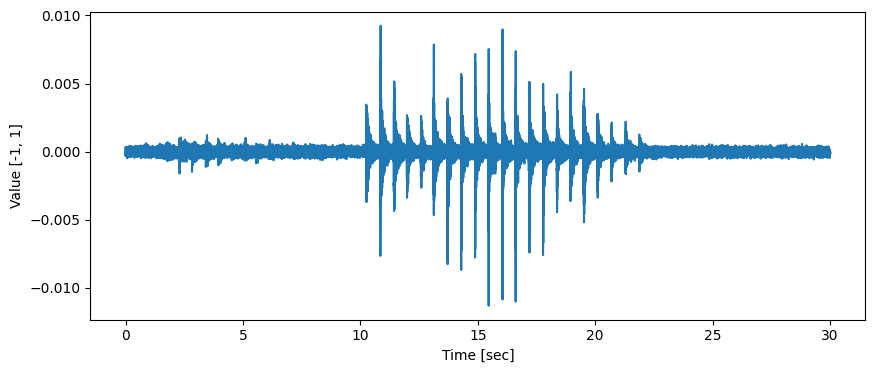

In [45]:
import wave
import numpy as np
import scipy.signal as sg
from pathlib import Path
import matplotlib.pyplot as plt

def calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c):
    # ysinΘ + xcosΘ
    """
    a: i x n_mic x 1 x n_bin
       方向数 x マイク数 x 1 x 周波数ビン数
    """
    rc = 0.0365
    mic_angle = np.array(
        [
            0,
            -np.pi / 4,
            -np.pi / 2,
            -np.pi * 3 / 4,
            np.pi,
            np.pi * 3 / 4,
            np.pi * 1 / 2,
            np.pi * 1 / 4,
        ]
    )
    a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64)
    for i, th in enumerate(theta):
        th = np.radians(th)
        for k in range(n_bin):
            fk = fs * k / N
            for m in range(n_mic):
                delay = -rc * np.cos(th - mic_angle[m]) / c
                a[i, m, 0, k] = np.exp(-1j * 2 * np.pi * fk * delay)
    return a


def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    # print("sample width:", wav.getsampwidth())
    # print("channel num:", wav.getnchannels())
    # print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    # print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data

def lower_bound(arr, num):
    left = 0
    right = len(arr) - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] <= num:
            left = mid + 1
        if arr[mid] > num:
            right = mid - 1
    # print("left: ", left, " right: ", right)
    return right


def MUSIC(file_name, t_left_sec, t_right_sec, start_angle, end_angle):
    n_mic = 8
    n_src = 3
    N = 512
    window = "hann"
    c = 340
    freq_l = 800
    freq_h = 3000

    fs = 16000
    k_l = int(freq_l / (fs / N))
    k_h = int(freq_h / (fs / N))

    audio = load_onefile(file_name)

    # print(audio.shape)
    f, t, X = sg.stft(audio, fs, window=window, nperseg=N)
    n_bin = X.shape[1]
    # print(t)
    t_left_index = lower_bound(t, t_left_sec)
    t_right_index = lower_bound(t, t_right_sec)

    theta = np.linspace(
        start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1
    )
    P_MU = np.zeros(theta.shape[0])

    a = calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c)
    # print(X.shape)
    X_trimed = X[:, :, t_left_index:t_right_index]
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    eig_val = np.zeros((n_mic, n_bin), dtype=np.complex64)
    eig_vec = np.zeros((n_mic, n_mic, n_bin), dtype=np.complex64)
    beta = np.zeros(n_bin)
    for k in range(n_bin):
        eig_val_k, eig_vec_k = np.linalg.eig(
            R[:, :, k]
        )  # 周波数ごとに固有値、固有ベクトルを算出
        sort = np.argsort(-1.0 * np.abs(eig_val_k))
        eig_val[:, k] = eig_val_k[sort]
        eig_vec[:, :, k] = eig_vec_k[:, sort]

    W = eig_vec[:, n_src:, :]
    beta = np.sum(np.abs(eig_val[:n_src, :]), axis=0)

    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHa = np.einsum("mik,mjk->ijk", aH, a[i])
        P_MU_th = np.einsum("mik,mek->iek", aH, W)
        P_MU_th = np.einsum("iek,jek->ijk", P_MU_th, np.conjugate(P_MU_th))
        P_MU_th = np.abs(aHa) / np.abs(P_MU_th)
        P_MU[i] = np.mean(beta[k_l : k_h + 1] * P_MU_th[0, 0, k_l : k_h + 1])

    P_MU = 10 * np.log10(P_MU)

    return P_MU

dir_name = str(Path.cwd().parent) + "/step_corner_datas/"
audio = load_onefile(dir_name + "walk_left600toright600_50_0.wav")
print(audio.shape)

sample_rate = 16000

x = np.array(range(audio.shape[1])) / sample_rate
print(x)

plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1, 1]")

print(audio[0])
plt.plot(x, audio[0])



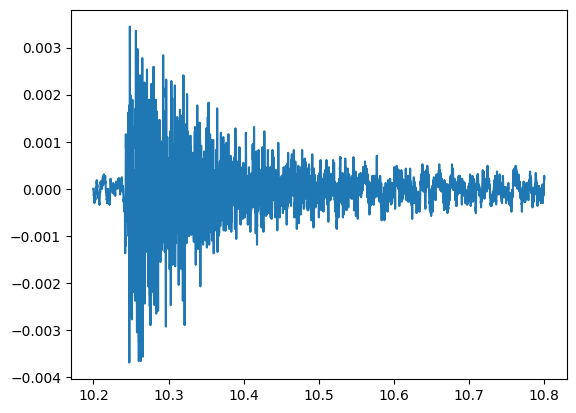

In [46]:
# 拡大する
start_time = 10.2
end_time = 10.8

start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

plt.plot(x[start_index:end_index], audio[0][start_index:end_index])
plt.show()

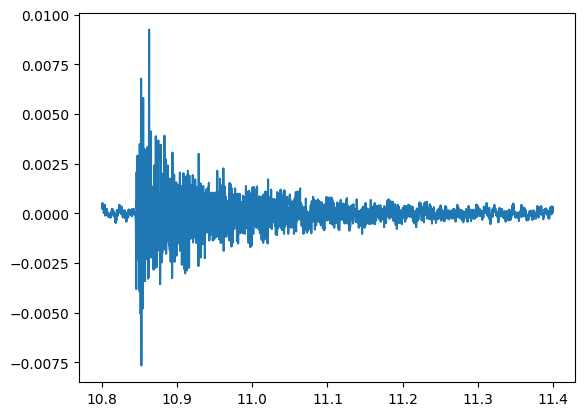

In [47]:
# 拡大する
start_time = 10.8
end_time = 11.4

start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

plt.plot(x[start_index:end_index], audio[0][start_index:end_index])
plt.show()

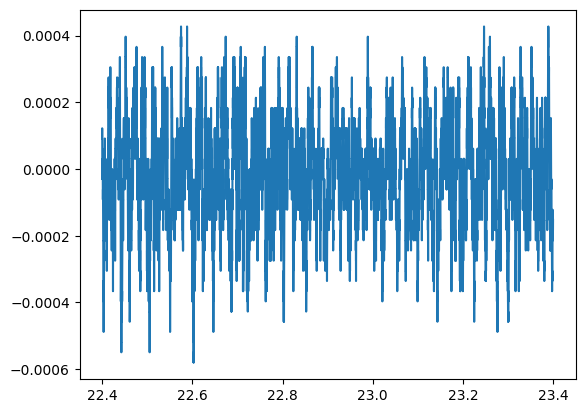

In [48]:
# 拡大する
start_time = 22.4
end_time = 23.4

start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

plt.plot(x[start_index:end_index], audio[0][start_index:end_index])
plt.show()

5


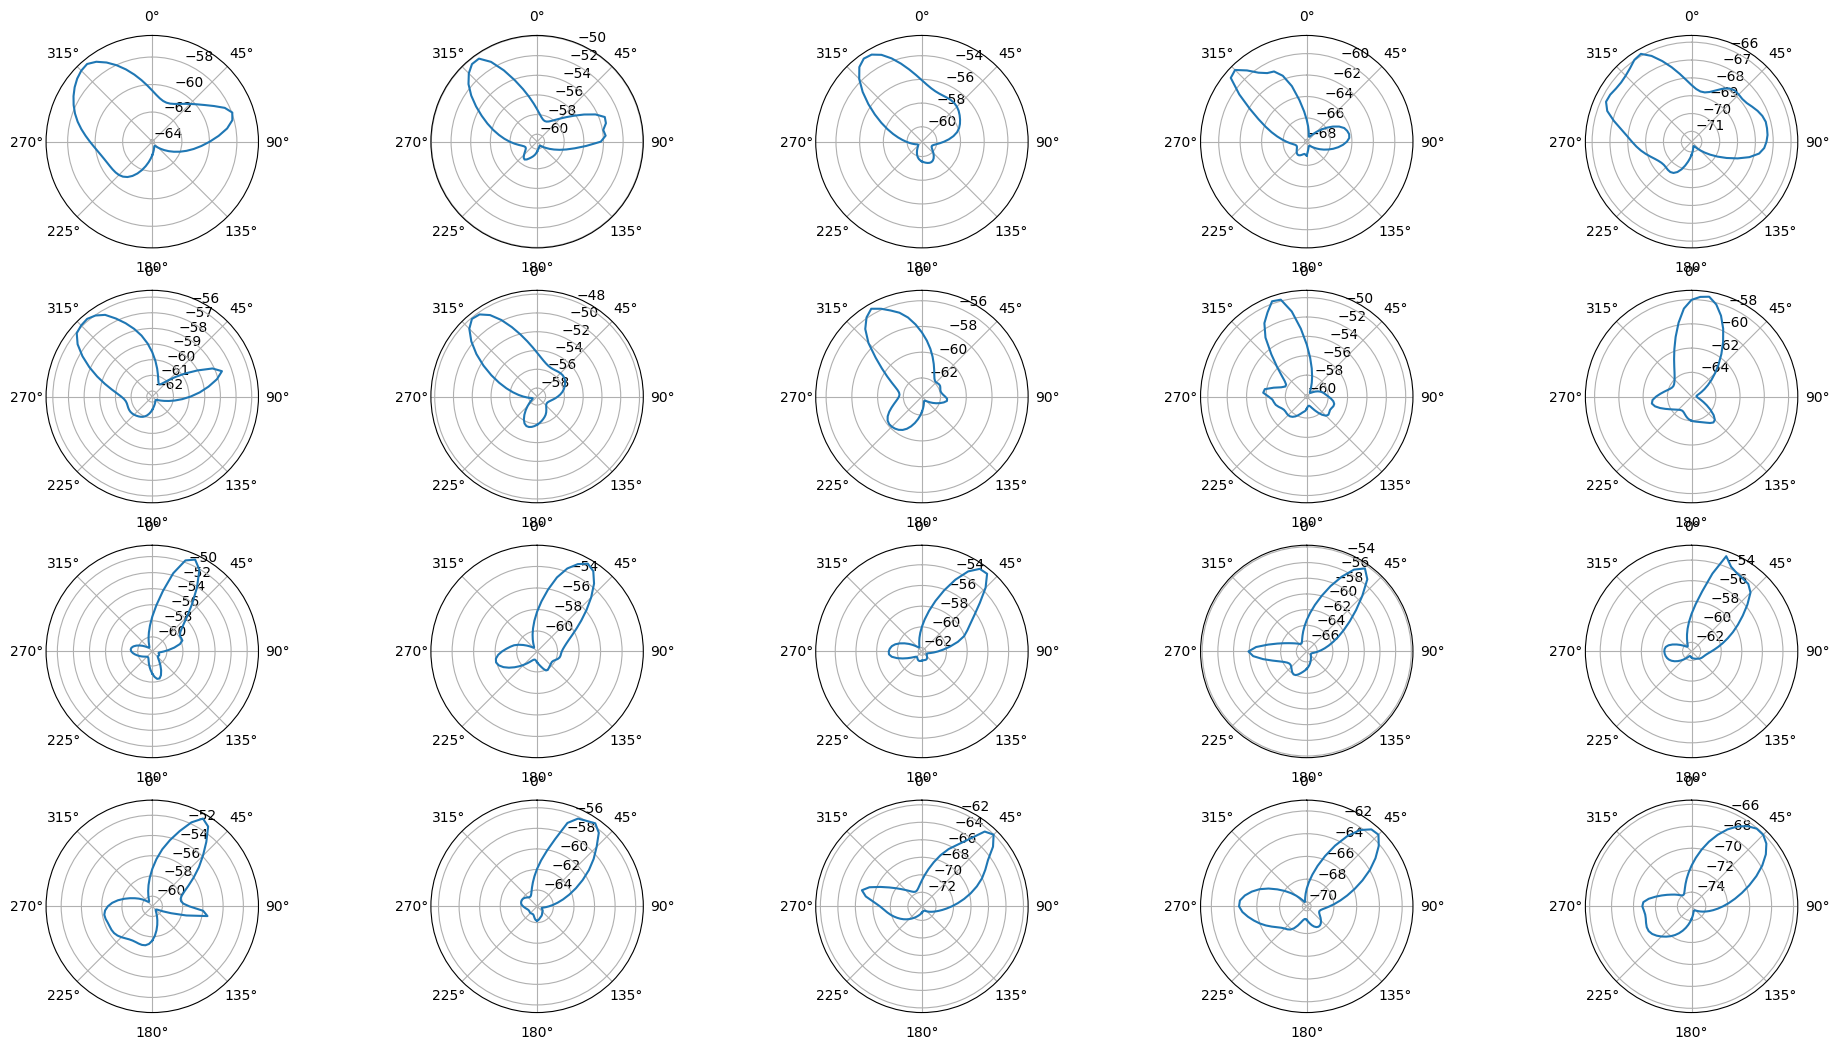

In [55]:
plt.figure(figsize=(24, 16))

dir_name = str(Path.cwd().parent) + "/step_corner_datas/"

file_name = dir_name + "walk_left600toright600_50_0.wav"
sample_rate = 16000

start_angle = -180
end_angle = 180
theta = np.linspace(start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1)
theta = np.deg2rad(theta)

t_sec_list = np.array([10.2, 10.8, 11.4, 11.9, 12.5, 13.1, 14.2, 14.8, 15.4, 16.0, 16.6, 17.1, 17.7, 18.3, 18.9, 19.4, 20.0, 20.6, 21.2, 21.8, 22.4])
interval_num = t_sec_list.shape[0]-1
row_num = 5
col_num = interval_num // row_num + 1
print(col_num)
for i in range(interval_num):
  P_MU = MUSIC(file_name, t_left_sec=t_sec_list[i], t_right_sec=t_sec_list[i+1], start_angle=start_angle, end_angle=end_angle)
  ax = plt.subplot(
    row_num, col_num, i+1, projection="polar"
  )
  ax.plot(theta, P_MU)
  ax.set_theta_zero_location("N")
  ax.set_theta_direction(-1)



[-2.74666585e-04 -2.13629566e-04 -2.44148076e-04 ...  6.10370190e-05
  6.10370190e-05  3.05185095e-05]


<Figure size 2400x1600 with 0 Axes>

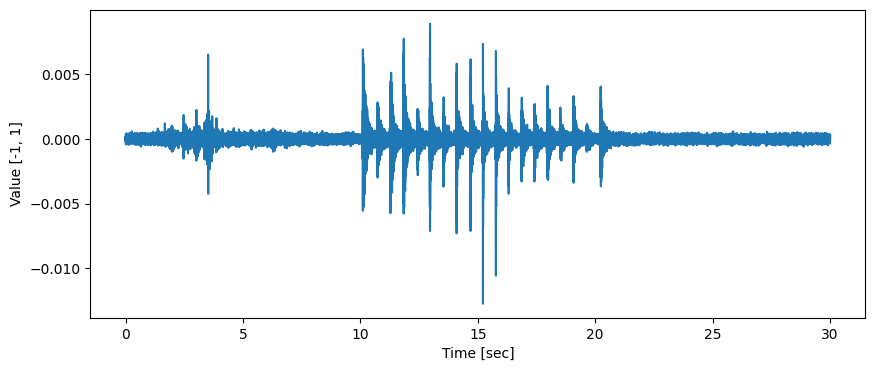

In [57]:
plt.figure(figsize=(24, 16))

dir_name = str(Path.cwd().parent) + "/step_corner_datas/"

file_name = dir_name + "walk_left600toright600_100_0.wav"
sample_rate = 16000

audio = load_onefile(file_name)
x = np.array(range(audio.shape[1])) / sample_rate
plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1, 1]")

print(audio[0])
plt.plot(x, audio[0])


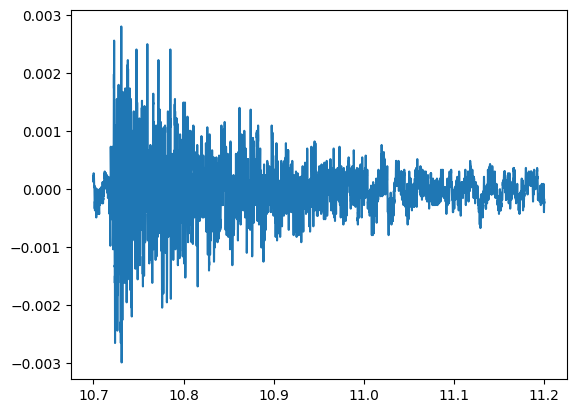

In [61]:
# 拡大する
start_time = 10.7
end_time = 11.2

start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

plt.plot(x[start_index:end_index], audio[0][start_index:end_index])
plt.show()

12


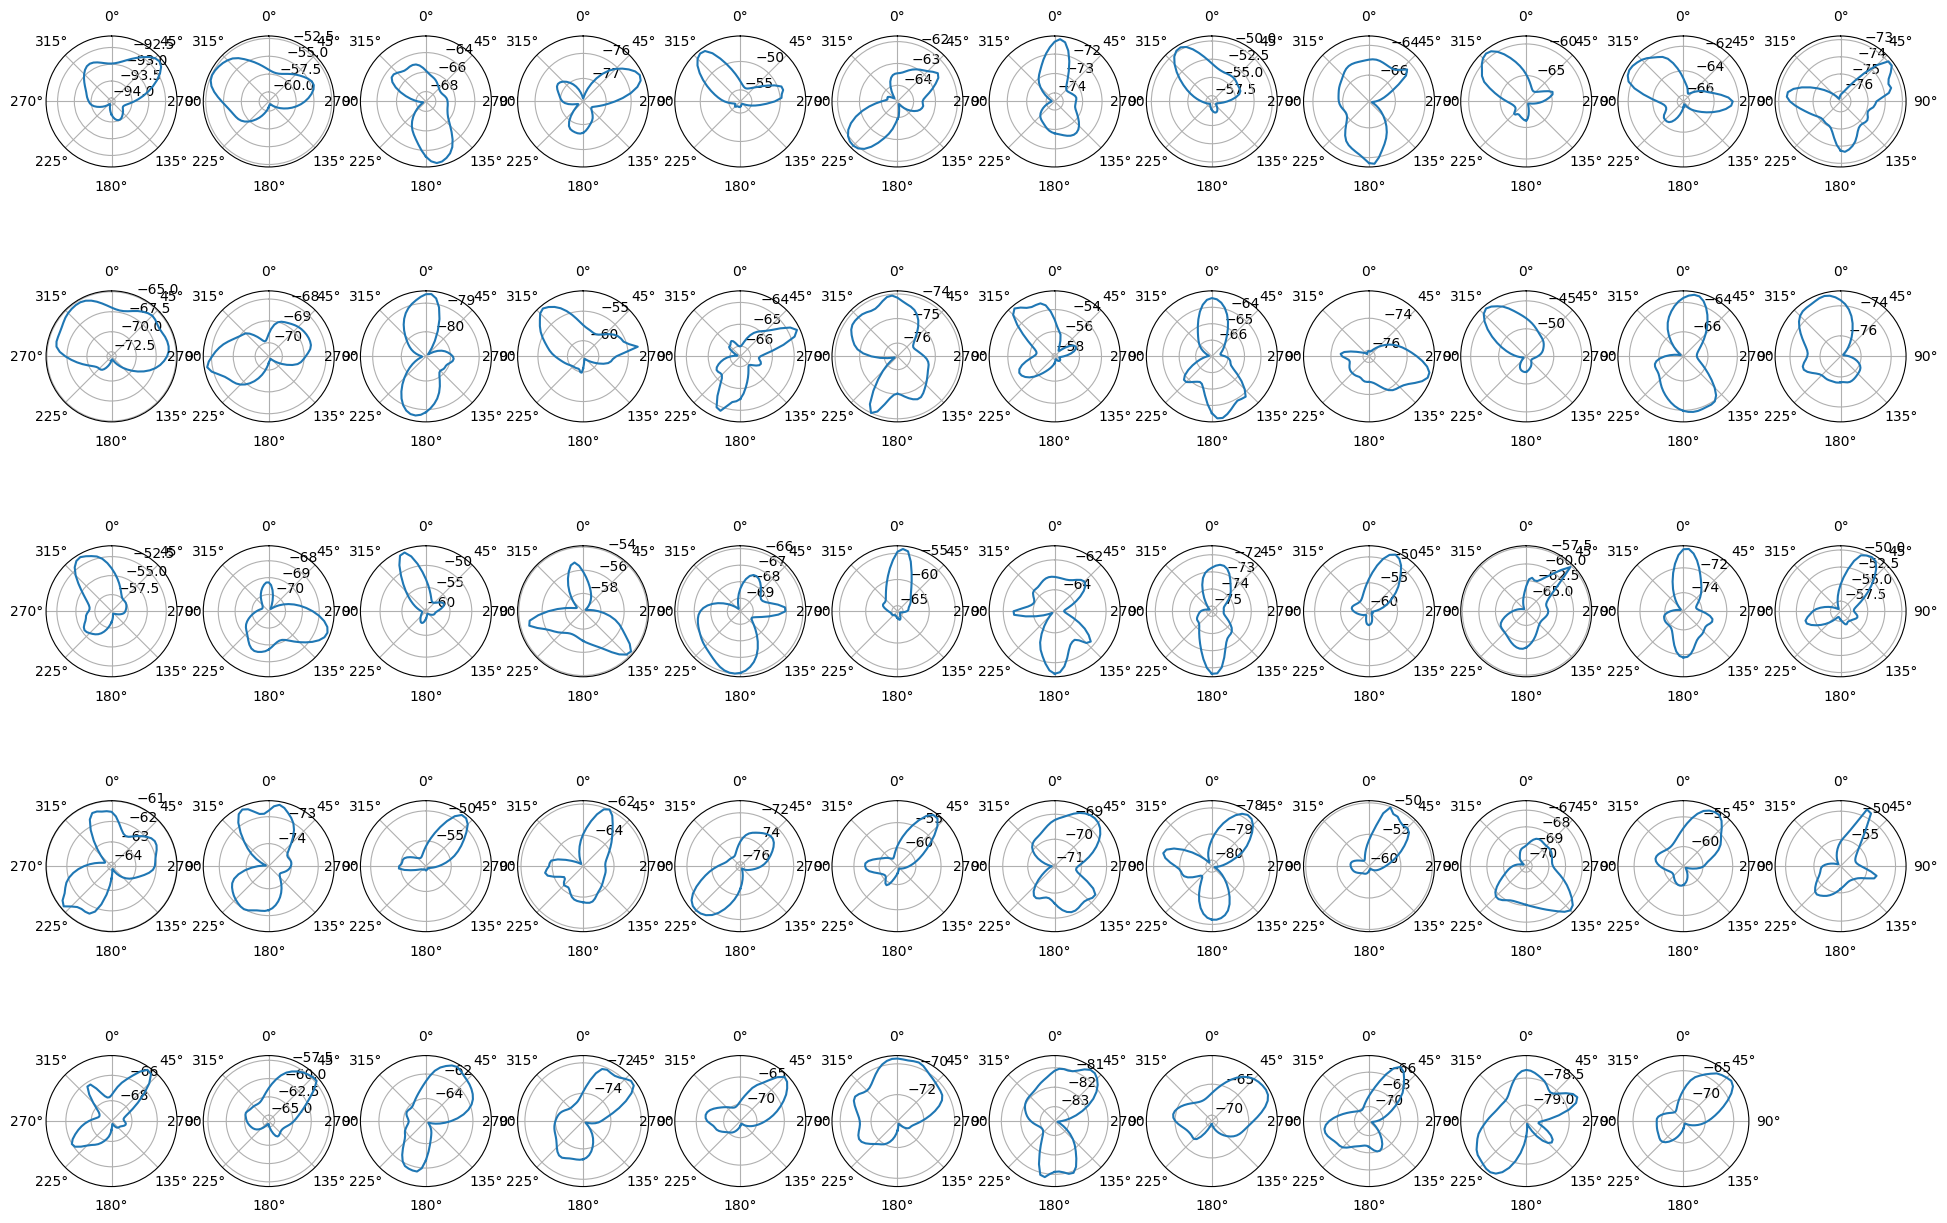

In [66]:
plt.figure(figsize=(24, 16))

dir_name = str(Path.cwd().parent) + "/step_corner_datas/"

file_name = dir_name + "walk_left600toright600_50_0.wav"
sample_rate = 16000

start_angle = -180
end_angle = 180
theta = np.linspace(start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1)
theta = np.deg2rad(theta)

t_sec_list = np.linspace(10,22, num=int((22 - 10) // 0.2) + 1)
interval_num = t_sec_list.shape[0]-1
row_num = 5
col_num = interval_num // row_num + 1
print(col_num)
for i in range(interval_num):
  P_MU = MUSIC(file_name, t_left_sec=t_sec_list[i], t_right_sec=t_sec_list[i+1], start_angle=start_angle, end_angle=end_angle)
  ax = plt.subplot(
    row_num, col_num, i+1, projection="polar"
  )
  ax.plot(theta, P_MU)
  ax.set_theta_zero_location("N")
  ax.set_theta_direction(-1)
